In [6]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd

In [7]:
def train_val_split():
    #read in pickle
    file_path = '../data/clean_data.pkl'
    df = pd.read_pickle(file_path)
    
    #sort dataframe by Store ID
    df.sort_values(by=['Date', 'Store'], inplace=True, ignore_index=True)
    
    #split dataset into features and target
    #k = int(df.shape[0] * relative_train)
    k = df[df['Date'] == '2014-03-30'].index.max()
    data_train = df.loc[:k, :]
    data_val = df.loc[k+1:, :]
    
    assert data_train['Date'].max() < data_val['Date'].min()
    
    #returns train and validation datasets
    return data_train, data_val

In [8]:
data_train, data_val = train_val_split()

In [9]:
def feature_engineering(df):
    #compute average sales per customer
    df.loc[df['Sales']<=0, 'sales_per_customer'] = 0
    df.loc[df['Sales']>0, 'sales_per_customer'] = df['Sales'] / df['Customers']
    
    #convert state holiday categories into yes(=1) and no(=0)
    df.loc[df['StateHoliday'].isin(['a', 'b', 'c']), 'state_holiday'] = 1
    df.loc[~df['StateHoliday'].isin(['a', 'b', 'c']), 'state_holiday'] = 0
    df.drop(['StateHoliday'], axis=1, inplace=True)
    
    #One hot encoding for store type, assortment
    cols = ['StoreType', 'Assortment']
    for col in cols:
        dummies = pd.get_dummies(df[col],prefix=col)
        df = pd.concat([df,dummies],axis=1)
        df.drop(col, axis=1, inplace=True)
    
    #convert Competition month-year into datetime
    df['D'] = 1.0     #helper column for day to be added to date
    df['Competition_open_since'] = pd.to_datetime(df.CompetitionOpenSinceYear*10000+df.CompetitionOpenSinceMonth*100+df.D, format='%Y%m%d')
    
    #determine whether Competition was active at the point in time
    comp = df['Competition_open_since'] <= df['Date']
    df.loc[comp, 'competition_active'] = 1
    df.loc[~comp, 'competition_active'] = 0
     
    
    #convert Promo 2 week-year into datetime
    df['helper_date'] = df.Promo2SinceYear * 1000 + df.Promo2SinceWeek * 10 + 0
    df['Promo_since'] = pd.to_datetime(df['helper_date'], format='%Y%W%w')
    
    #determine whether Promo2 was active during the month
    months = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6, 'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}
    promo_start_later = df['Promo_since'] > df['Date']

    for key, value in months.items():
        df.loc[(df['PromoInterval'].str.contains(key)) & (df['Date'].dt.month == value), 'Promo2_active'] = 1
    df.loc[promo_start_later, 'Promo2_active'] = 0
    df['Promo2_active'].fillna(0, inplace=True)
    
    
    #delete irrelevant columns
    df.drop(['D',
            'helper_date',
            'CompetitionOpenSinceYear',
            'CompetitionOpenSinceMonth',
            'Competition_open_since',
            'Promo2SinceYear',
            'Promo2SinceWeek',
            'Promo2',
            'PromoInterval',
            'Promo_since'], axis=1, inplace=True)
    
    return df

In [10]:
train_enh = feature_engineering(data_train)

In [11]:
train_enh

,Date,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,CompetitionDistance,sales_per_customer,state_holiday,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,competition_active,Promo2_active
0,2013-01-01,1.0,2.0,0.0,0.0,0.0,0.0,1.0,1270.0,0.0,1.0,0,0,1,0,1,0,0,1.0,0.0
1,2013-01-01,2.0,2.0,0.0,0.0,0.0,0.0,1.0,570.0,0.0,1.0,1,0,0,0,1,0,0,1.0,1.0
2,2013-01-01,3.0,2.0,0.0,0.0,0.0,0.0,1.0,14130.0,0.0,1.0,1,0,0,0,1,0,0,1.0,1.0
3,2013-01-01,4.0,2.0,0.0,0.0,0.0,0.0,1.0,620.0,0.0,1.0,0,0,1,0,0,0,1,1.0,0.0
4,2013-01-01,5.0,2.0,0.0,NaN,0.0,0.0,1.0,29910.0,0.0,1.0,1,0,0,0,1,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
506204,2014-03-30,NaN,7.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0,0,0,0,0,0,0,0.0,0.0
506205,2014-03-30,NaN,7.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0,0,0,0,0,0,0,0.0,0.0
506206,2014-03-30,NaN,7.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,0,0,0,0,0,0,0,0.0,0.0
506207,2014-03-30,NaN,7.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0,0,0,0,0,0,0,0.0,0.0


<AxesSubplot:xlabel='Date'>

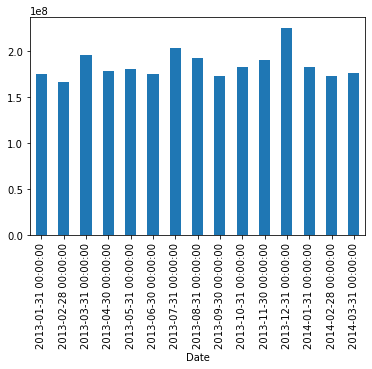

In [12]:
train_enh.index = train_enh['Date']
train_enh.resample('M').sum()['Sales'].plot(kind='bar')

<AxesSubplot:xlabel='DayOfWeek'>

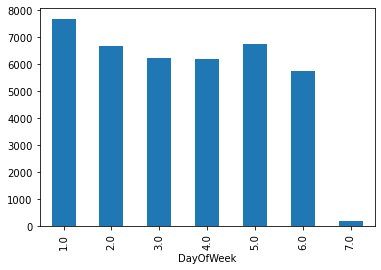

In [13]:
train_enh.groupby('DayOfWeek').mean()['Sales'].plot(kind='bar')

<AxesSubplot:xlabel='DayOfWeek'>

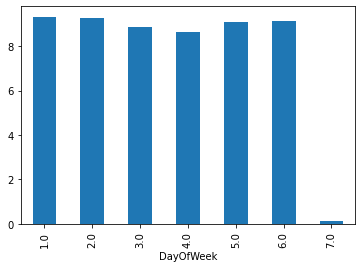

In [14]:
train_enh.groupby('DayOfWeek').mean()['sales_per_customer'].plot(kind='bar')

<AxesSubplot:xlabel='Promo'>

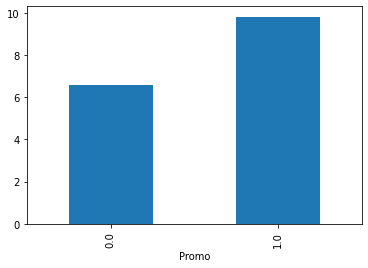

In [15]:
train_enh.groupby('Promo').mean()['sales_per_customer'].plot(kind='bar')

<AxesSubplot:xlabel='Promo2_active'>

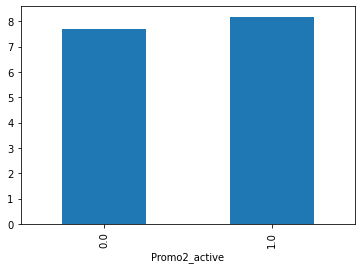

In [16]:
train_enh.groupby('Promo2_active').mean()['sales_per_customer'].plot(kind='bar')

<AxesSubplot:xlabel='SchoolHoliday'>

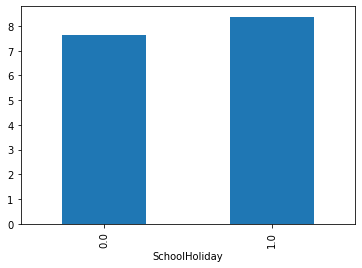

In [18]:
train_enh.groupby('SchoolHoliday').mean()['sales_per_customer'].plot(kind='bar')

<AxesSubplot:xlabel='competition_active'>

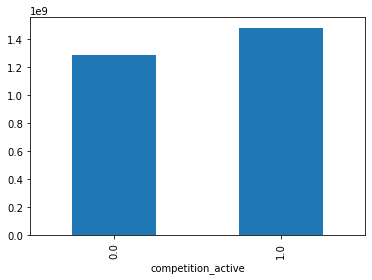

In [21]:
train_enh.groupby('competition_active').sum()['Sales'].plot(kind='bar')

<AxesSubplot:xlabel='CompetitionDistance', ylabel='Sales'>

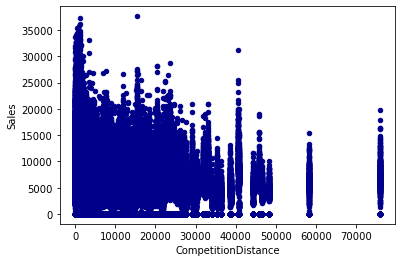

In [22]:
train_enh.plot.scatter(x='CompetitionDistance', y='Sales', c='DarkBlue')

<AxesSubplot:xlabel='CompetitionDistance', ylabel='Customers'>

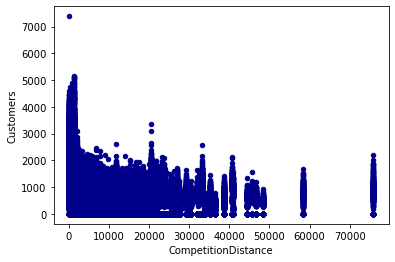

In [24]:
train_enh.plot.scatter(x='CompetitionDistance', y='Customers', c='DarkBlue')

In [41]:
monthly_sales = train_enh.groupby([train_enh.index, 'Store']).sum()
monthly_sales.head(15)

DayOfWeek  Sales  Customers  Open  Promo  SchoolHoliday  \
Date       Store                                                            
2013-01-01 1.0          2.0    0.0        0.0   0.0    0.0            1.0   
           2.0          2.0    0.0        0.0   0.0    0.0            1.0   
           3.0          2.0    0.0        0.0   0.0    0.0            1.0   
           4.0          2.0    0.0        0.0   0.0    0.0            1.0   
           5.0          2.0    0.0        0.0   0.0    0.0            1.0   
           6.0          2.0    0.0        0.0   0.0    0.0            1.0   
           7.0          2.0    0.0        0.0   0.0    0.0            1.0   
           8.0          0.0    0.0        0.0   0.0    0.0            1.0   
           9.0          2.0    0.0        0.0   0.0    0.0            1.0   
           10.0         2.0    0.0        0.0   0.0    0.0            1.0   
           11.0         2.0    0.0        0.0   0.0    0.0            1.0   
           12.0         2.0    0.0        0.0   0.0    0.0            1.0   
           13.0         2.0    0.0        0.0   0.0    0.0            1.0   
           14.0         2.0    0.0        0.0   0.0    0.0            1.0   
           15.0         2.0    0.0        0.0   0.0    0.0            0.0   

                  CompetitionDistance  sales_per_customer  state_holiday  \
Date       Store                                                           
2013-01-01 1.0                 1270.0                 0.0            1.0   
           2.0                  570.0                 0.0            1.0   
           3.0                14130.0                 0.0            1.0   
           4.0                  620.0                 0.0            1.0   
           5.0                29910.0                 0.0            1.0   
           6.0                  310.0                 0.0            1.0   
           7.0                24000.0                 0.0            1.0   
           8.0                 7520.0                 0.0            1.0   
           9.0                 2030.0                 0.0            1.0   
           10.0                3160.0                 0.0            1.0   
           11.0                 960.0                 0.0            1.0   
           12.0                1070.0                 0.0            1.0   
           13.0                 310.0                 0.0            1.0   
           14.0                1300.0                 0.0            1.0   
           15.0                4110.0                 0.0            1.0   

                  StoreType_a  StoreType_b  StoreType_c  StoreType_d  \
Date       Store                                                       
2013-01-01 1.0              0            0            1            0   
           2.0              1            0            0            0   
           3.0              1            0            0            0   
           4.0              0            0            1            0   
           5.0              1            0            0            0   
           6.0              1            0            0            0   
           7.0              1            0            0            0   
           8.0              1            0            0            0   
           9.0              1            0            0            0   
           10.0             1            0            0            0   
           11.0             1            0            0            0   
           12.0             1            0            0            0   
           13.0             0            0            0            1   
           14.0             1            0            0            0   
           15.0             0            0            0            1   

                  Assortment_a  Assortment_b  Assortment_c  \
Date       Store                                             
2013-01-01 1.0               1             0             0   
    